# <center><b> Práctica 2 de Laboratorio 5 </b><br><u> Espectroscopía Láser </u></center>

Grupo 1: Trinidad Borrel, Bruno Sivilotti, Agustín Brusco

In [143]:
import numpy as np
import scipy.constants as cte
import matplotlib.pyplot as plt
# Formato para matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.xmargin'] = 0

In [161]:
FREQS_RUBIDIO85 = np.array([3.61780000e+08, 3.03573244e+09, 3.77105833e+14, 3.77108868e+14, 3.77256703e+14, 3.77257968e+14, 3.77259738e+14])  # Hz
FREQS_RUBIDIO87 = np.array([8.14500000e+08, 6.83468261e+09, 3.77104391e+14, 3.77105206e+14, 3.77111226e+14, 3.88112040e+14])  # Hz
freqs_rubidio = np.sort(np.concatenate([FREQS_RUBIDIO85, FREQS_RUBIDIO87]))  # Hz
print(*[f'{f*1e-9:.6g} GHz' for f in freqs_rubidio], sep=', ')

0.36178 GHz, 0.8145 GHz, 3.03573 GHz, 6.83468 GHz, 377104 GHz, 377105 GHz, 377106 GHz, 377109 GHz, 377111 GHz, 377257 GHz, 377258 GHz, 377260 GHz, 388112 GHz


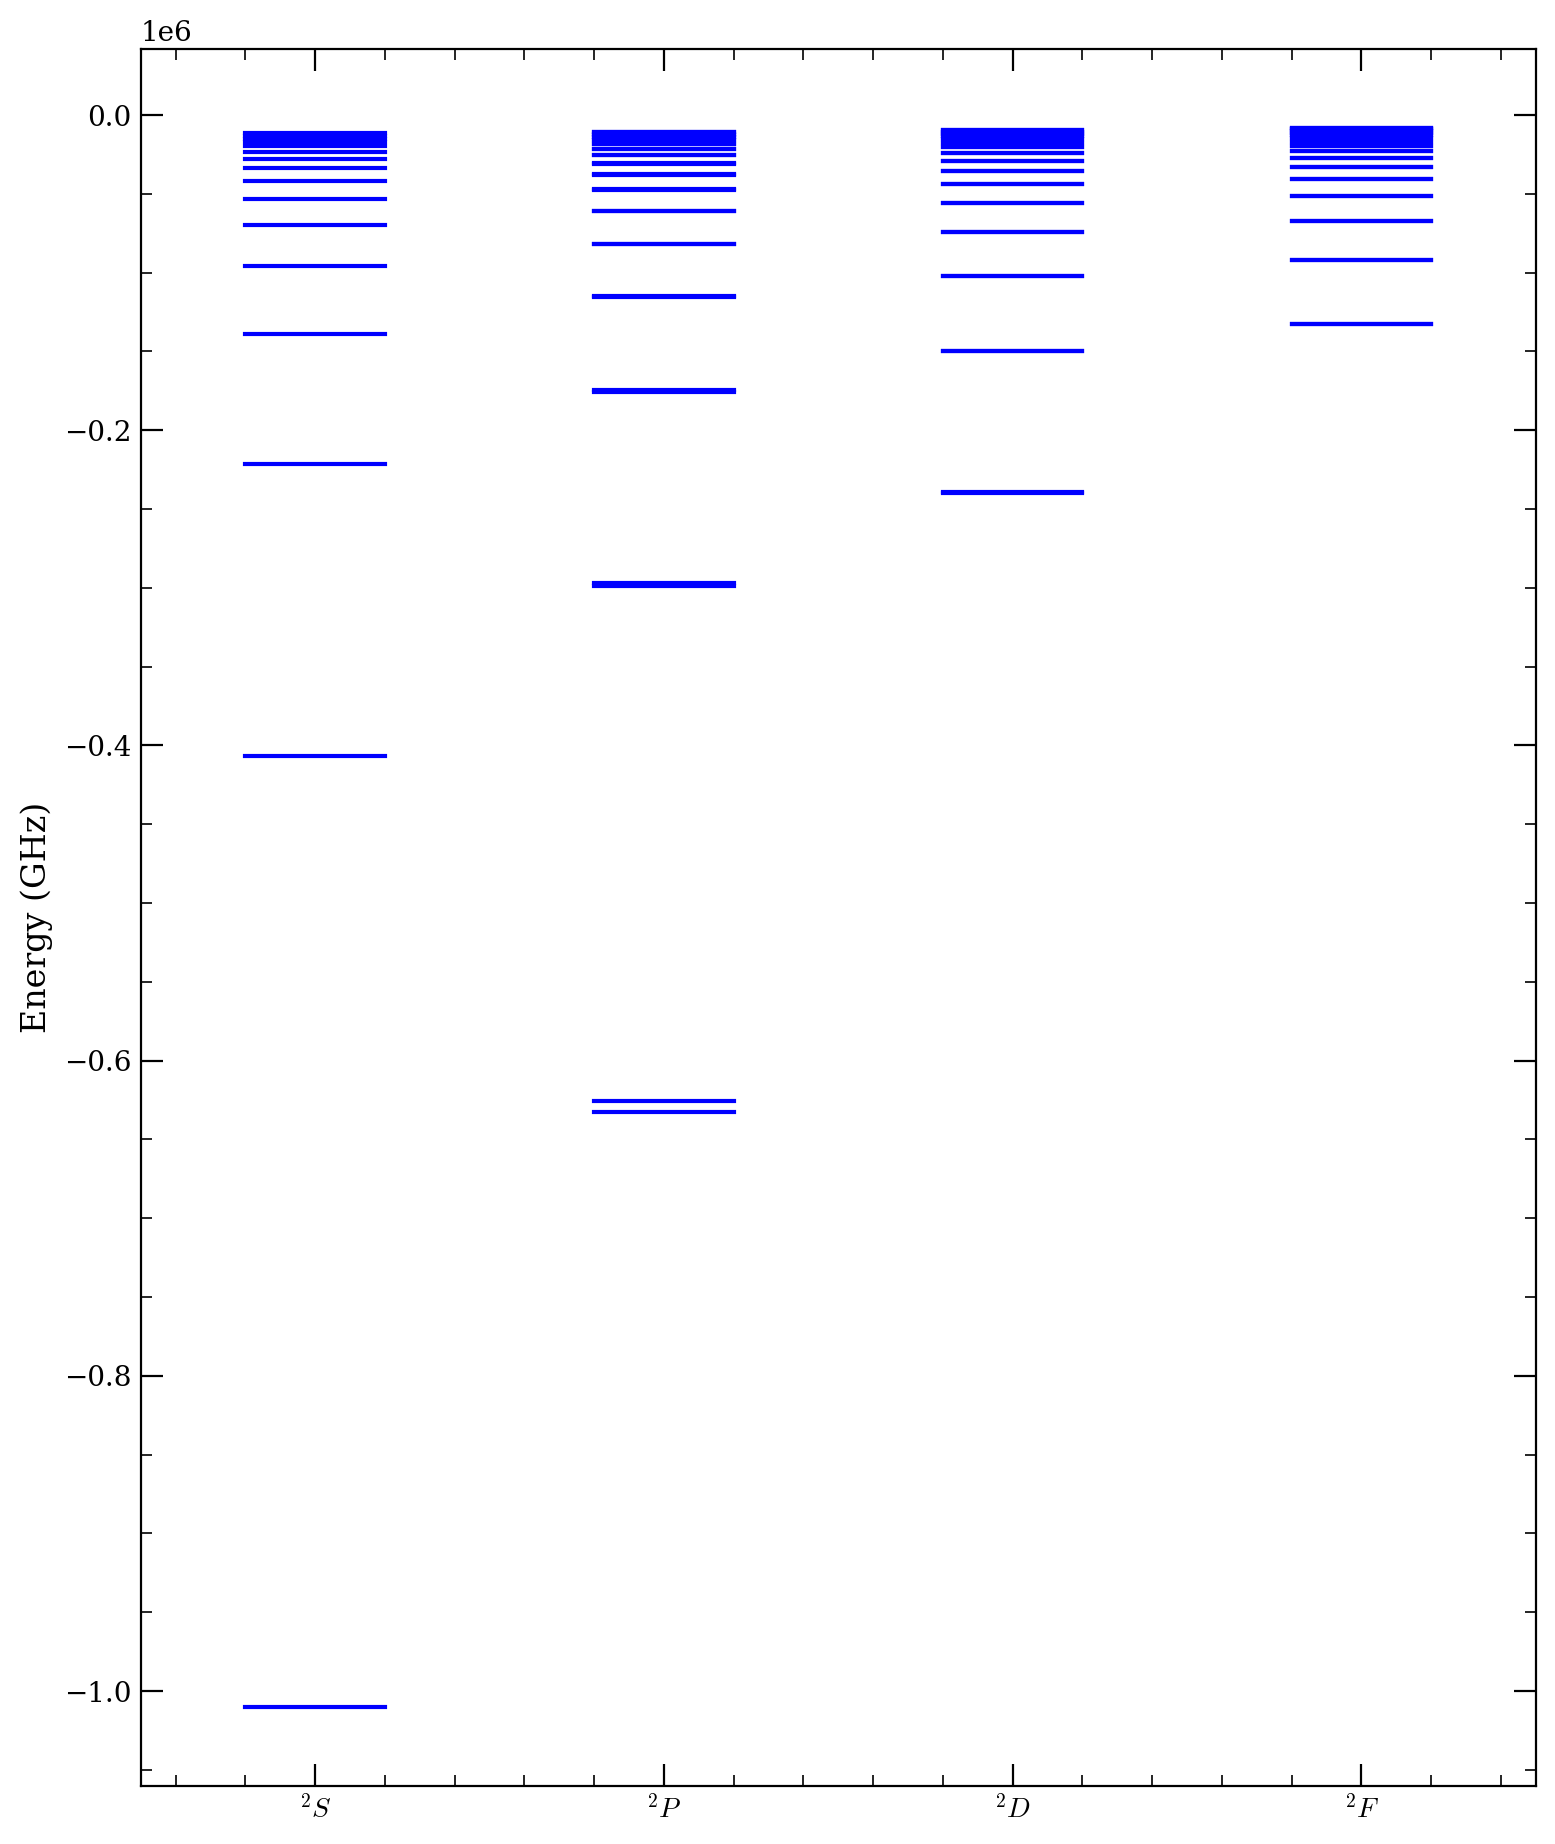

In [148]:
from arc.alkali_atom_data import Rubidium
from arc import LevelPlot

rb_atom = Rubidium()
# rb_atom.getEnergy(n=5, l=0, j=1/2)  # eV

levels = LevelPlot(rb_atom)
levels.makeLevels(5, 20, 0, 3)
levels.drawLevels('GHz')
levels.showPlot()

In [131]:
Temps_arr = np.arange(2125, 2375 + 1, 25)  # 100 × °C
times_arr = np.zeros((2500, Temps_arr.size))  # s
V1 = np.zeros_like(times_arr)  # V
V2 = np.zeros_like(times_arr)  # V
for i, temp_tag in enumerate(Temps_arr):
    file = f'pendiente{temp_tag}.npy'
    times_arr[:, i], V1[:, i], V2[:, i] = np.load(file)

In [165]:
def corriente_a_frecuencia(corriente, freq_ru, corriente_forzada):
    m = -(freq_ru.max() - freq_ru.min())/(corriente_forzada.max() - corriente_forzada.min())
    return m*(corriente - corriente_forzada.min()) + freq_ru.max()


def lineal(t, a, b):
    return a*t + b

In [168]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

freqs_arr = np.zeros_like(times_arr)
# Hipotesis: los picos de tensión se asocian a los picos de corriente
corriente_setpoint = 1.4e-3  # A : Valor medio de las oscilaciones
corriente_depth = 0.1/100
corriente_max = corriente_setpoint*(1+corriente_depth)  # A
corriente_min = corriente_setpoint*(1-corriente_depth)  # A
corriente_rango = corriente_max - corriente_min  # A
for i, (tiempo, channel1) in enumerate(zip(times_arr.T, V1.T)):
    print(i)
    t_max = tiempo[np.argmax(channel1)]  # s
    t_min = tiempo[np.argmin(channel1)]  # s
    m = (corriente_max - corriente_min)/(t_max - t_min)  # A/s

    corriente1 = m*(tiempo - t_min) + corriente_min  # A
    popt, pcov = curve_fit(lineal, corriente1, channel1)

    peaks = find_peaks(-(channel1 - lineal(corriente1, *popt)), distance=15, prominence=0.01)[0]

    picos_forzados = corriente1[peaks[[-3, -1]]]  # A

    # for idx1 in range(4, 8):
    #     for idx2 in range(idx1+1, 9):
    idx1 = 6
    idx2 = 7
    freqs_arr[:, i] = corriente_a_frecuencia(corriente1, freqs_rubidio[[idx1, idx2]], picos_forzados)

0
1
2
3
4
5
6


IndexError: index -3 is out of bounds for axis 0 with size 2

/tmp/ipykernel_11439/2091540039.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(Temps_arr*1e-2, times_arr*1e3, V2, shading='auto')


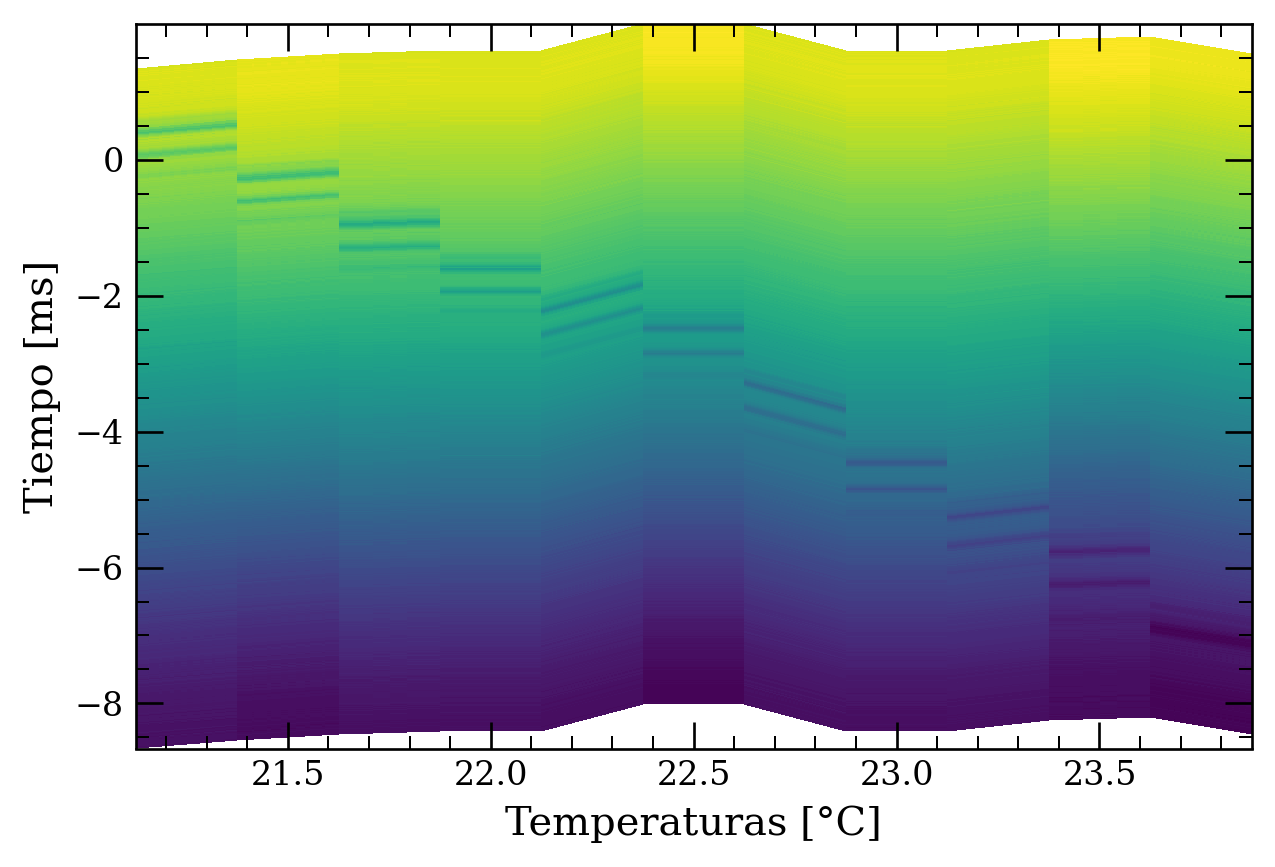

In [132]:
plt.figure()
plt.pcolormesh(Temps_arr*1e-2, times_arr*1e3, V2, shading='auto')
plt.xlabel("Temperaturas [°C]")
plt.ylabel("Tiempo [ms]")
plt.show()